## Name: Signed Distance of features instead of simple distance based kernels.
### Date: 07/8/2024
### Status: Somewhat works. Need to work on the idea more.
### Idea: 
The idea stemmed from thinking that instead of using a distance gramm matrix, which is agnostic of the labels, we could incorporate the labels as well.
So we transfrom D(x,y) = -D(x,y) if y==0 else D(x,y) (with y==1).

### Results:
Seems to work on linear kernel with DT on top.
linear signed is better on 29/63 datasets, it is worse in 24/63 and they tied the rest..

In [ ]:
WINS
                  DT  linear_svm  poly_svm  linear_signed_  linear_orig_
DT               0.0        42.0      41.0            47.0          45.0
linear_svm      19.0         0.0      26.0            33.0          34.0
poly_svm        19.0        26.0       0.0            32.0          34.0
linear_signed_  14.0        29.0      28.0             0.0          29.0
linear_orig_    14.0        28.0      27.0            23.0           0.0

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
from pmlb import fetch_data
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:

random_state = 42
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

X, y = load_breast_cancer(return_X_y=True)

In [117]:
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import pairwise_distances, pairwise_kernels
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


kernel = 'linear'

clf = RandomForestClassifier(random_state=random_state)# DecisionTreeClassifier(random_state=random_state) 

y_pred_all = []
y_true_all = []
for train, test in cv.split(X,y):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    
    y_train[y_train == 0] = -1
    y_test[y_test == 0] = -1
    
    
    train_2_train = pairwise_kernels(X_train, X_train, metric=kernel) #* y_train 
    
    
    #train_2_train = np.einsum('ij,j->ij',train_2_train, y_train)
    test_2_train = pairwise_kernels(X_test, X_train, metric=kernel) #* y_train
    
    #test_2_train = np.einsum('ij,j->ij',test_2_train, y_train)
    
    cur_clf = clone(clf)
    cur_clf.fit(train_2_train, y_train)
    y_pred = cur_clf.predict(test_2_train)
    y_pred_all.extend(y_pred.tolist())
    y_true_all.extend(y_test.tolist())
    
print(classification_report(y_true_all, y_pred_all))
print(confusion_matrix(y_true_all, y_pred_all))

              precision    recall  f1-score   support

          -1       0.88      0.84      0.86       212
           1       0.91      0.93      0.92       357

    accuracy                           0.90       569
   macro avg       0.89      0.89      0.89       569
weighted avg       0.90      0.90      0.90       569

[[178  34]
 [ 24 333]]


In [4]:
from sklearn.metrics import pairwise_distances, pairwise_kernels


y_pred_all = []
y_true_all = []
for train, test in cv.split(X,y):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    
    y_train[y_train == 0] = -1
    y_test[y_test == 0] = -1
    
    
    
    train_2_train = pairwise_kernels(X_train, X_train, metric=kernel) #* y_train 
    
    y_train_repeated = np.repeat(y_train.reshape(1,-1), repeats=[len(train_2_train)], axis=0)
    
    train_2_train = train_2_train * y_train_repeated
    
    #train_2_train = np.einsum('ij,j->ij',train_2_train, y_train)
    test_2_train = pairwise_kernels(X_test, X_train, metric=kernel) #* y_train
    
    y_train_test_repeated = np.repeat(y_train.reshape(1,-1), repeats=[len(test_2_train)], axis=0)
    
    test_2_train = test_2_train * y_train_test_repeated
    
    #test_2_train = np.einsum('ij,j->ij',test_2_train, y_train)
    
    cur_clf = clone(clf)
    cur_clf.fit(train_2_train, y_train)
    y_pred = cur_clf.predict(test_2_train)
    y_pred_all.extend(y_pred.tolist())
    y_true_all.extend(y_test.tolist())
    
print(classification_report(y_true_all, y_pred_all))
print(confusion_matrix(y_true_all, y_pred_all))

              precision    recall  f1-score   support

          -1       0.87      0.84      0.85       212
           1       0.91      0.92      0.92       357

    accuracy                           0.89       569
   macro avg       0.89      0.88      0.88       569
weighted avg       0.89      0.89      0.89       569

[[178  34]
 [ 27 330]]


In [311]:
from sklearn.metrics import pairwise_distances, pairwise_kernels
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


y_pred_all = []
y_true_all = []
kernel = 'euclidean'


# clf = Pipeline([
#     ('sc', StandardScaler()),
#     ('clf', RandomForestClassifier(random_state=random_state))
# ])
clf = RandomForestClassifier(random_state=random_state)# RandomForestClassifier(random_state=random_state)#

for train, test in cv.split(X,y):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    
    y_train[y_train == 0] = -1
    y_test[y_test == 0] = -1
    
    
    
    train_2_train = pairwise_distances(X_train, X_train, metric=kernel) #* y_train 
    
    # To counter the effect of zeros we sort them by closest to furthest and remove the zero
    # Resulting at train_num-1 features.
    # At test time, we remove the furthest value as we calculate will have the least impact
    train_sort_neighbors_per_sample = np.argsort(train_2_train, axis=1)
    
    train_2_train = train_2_train[np.arange(len(train_2_train))[:,None],train_sort_neighbors_per_sample]
    
    sign_matrix = y_train.reshape(-1,1) @ y_train.reshape(1,-1)
    sign_matrix = sign_matrix[np.arange(len(sign_matrix))[:,None], train_sort_neighbors_per_sample]
    train_2_train_signed = train_2_train * sign_matrix
    train_2_train_signed = train_2_train_signed[:,1:]
    
    #train_2_train = np.einsum('ij,j->ij',train_2_train, y_train)
    test_2_train = pairwise_distances(X_test, X_train, metric=kernel) #* y_train
    test_sort_neighbors_per_sample = np.argsort(test_2_train, axis=1)
    
    test_2_train = test_2_train[np.arange(len(test_2_train))[:,None],test_sort_neighbors_per_sample]
    
    test_sign_matrix_pos = np.ones(len(X_test)).reshape(-1,1) @ y_train.reshape(1,-1)
    test_sign_matrix_pos = test_sign_matrix_pos[np.arange(len(test_sign_matrix_pos))[:,None], test_sort_neighbors_per_sample]
    
    test_2_train_pos = test_2_train * test_sign_matrix_pos
    test_2_train_pos = test_2_train_pos[:,:-1]
    
    test_sign_matrix_neg = -test_sign_matrix_pos
    test_sign_matrix_neg = test_sign_matrix_neg[np.arange(len(test_sign_matrix_neg))[:,None], test_sort_neighbors_per_sample]
    test_2_train_neg = test_2_train * test_sign_matrix_neg
    test_2_train_neg = test_2_train_neg[:,:-1]
    
    
    sc = StandardScaler()
    train_2_train_signed = sc.fit_transform(train_2_train_signed)
    test_2_train_pos = sc.transform(test_2_train_pos)
    test_2_train_neg = sc.transform(test_2_train_neg)
    
    cur_clf = clone(clf)
    cur_clf.fit(train_2_train_signed, y_train)
    print(f'TRAIN score: {cur_clf.score(train_2_train_signed, y_train)}')
    y_pred_pos = cur_clf.predict_proba(test_2_train_pos)
    y_pred_neg = cur_clf.predict_proba(test_2_train_neg)
    
    # ## MLE ##
    
    means = np.mean(train_2_train_signed, axis=0)
    # covs = np.cov(treain_2_train_signed, rowvar=False)
    
    from sklearn.covariance import ShrunkCovariance
    covs = ShrunkCovariance().fit(train_2_train_signed).covariance_

    
    from scipy.stats import multivariate_normal
    from sklearn.preprocessing import MinMaxScaler
    g = multivariate_normal(means, covs, allow_singular=True)
    # pos_likelihood = g.pdf(test_2_train_pos)
    # neg_likelihood = g.pdf(test_2_train_neg)
    pos_likelihood = MinMaxScaler().fit_transform(g.logpdf(test_2_train_pos).reshape(-1,1)).ravel()
    neg_likelihood = 1 - pos_likelihood #MinMaxScaler().fit_transform(g.logpdf(test_2_train_neg).reshape(-1,1)).ravel()
    
    y_pos = y_pred_pos[:, 1] #* pos_likelihood**(1)
    y_neg = y_pred_neg[:, 0] #* neg_likelihood**(1)
    
    y_pred = (y_pos>y_neg).astype(int)#(pos_likelihood > neg_likelihood).astype(int)#
    #y_pred = (( y_pred_pos[:,1] + y_pred_neg[:,0] ) / 2 > 0.5).astype(int)
    y_pred[y_pred == 0] = -1
    
    y_pred_all.extend(y_pred.tolist())
    y_true_all.extend(y_test.tolist())
    #break
    
print(classification_report(y_true_all, y_pred_all))
print(confusion_matrix(y_true_all, y_pred_all))

TRAIN score: 1.0
TRAIN score: 1.0
TRAIN score: 1.0
TRAIN score: 1.0
TRAIN score: 1.0
TRAIN score: 1.0
TRAIN score: 1.0
TRAIN score: 1.0
TRAIN score: 1.0
TRAIN score: 1.0
              precision    recall  f1-score   support

          -1       0.96      0.76      0.85       212
           1       0.88      0.98      0.93       357

    accuracy                           0.90       569
   macro avg       0.92      0.87      0.89       569
weighted avg       0.91      0.90      0.90       569

[[162  50]
 [  6 351]]


In [292]:
pos_likelihood

array([0.0570956 , 0.0413995 , 0.61852362, 0.31178119, 0.0058888 ,
       0.19066083, 0.01238385, 0.64921265, 0.15513445, 0.17577428,
       0.01060588, 0.        , 0.18315931, 0.62984629, 0.05460237,
       0.69545459, 0.18102912, 0.47647135, 0.01413328, 0.69930682,
       0.81231982, 0.70744076, 0.03683333, 0.58260724, 0.0490715 ,
       0.00806122, 0.57369119, 0.00547379, 0.17756392, 0.1445992 ,
       0.08514906, 0.03574965, 0.67359731, 0.63696139, 0.8610784 ,
       0.71543777, 0.01871419, 0.97888008, 0.0362172 , 0.01251845,
       0.45841842, 0.01173448, 0.02356715, 0.00880145, 0.05592427,
       0.55942778, 0.00776406, 0.00632291, 0.04300332, 0.11211373,
       0.02441662, 0.00221053, 0.63271704, 0.01884269, 0.14759646,
       1.        , 0.88122381])

In [279]:
MinMaxScaler().fit_transform(g.logpdf(test_2_train_neg).reshape(-1,1)).ravel()

array([0.99540797, 0.99435922, 0.69734925, 0.99594029, 0.99689406,
       0.99762642, 0.93392378, 0.99394281, 0.96407388, 0.97577406,
       0.91546816, 0.68053271, 0.99902761, 0.99869118, 0.98341443,
       1.        , 0.98398718, 0.9893637 , 0.99149974, 0.83366953,
       0.9974062 , 0.99732452, 0.9880731 , 0.99659903, 0.99477408,
       0.94584995, 0.86094965, 0.9989683 , 0.99854147, 0.98507962,
       0.99451148, 0.        , 0.99721974, 0.99836353, 0.98790375,
       0.99842164, 0.99969731, 0.79497702, 0.99596382, 0.9974311 ,
       0.92900833, 0.99780531, 0.91915389, 0.99736412, 0.99517583,
       0.98356341, 0.994431  , 0.98822936, 0.98181233, 0.97204107,
       0.90911988, 0.95914144, 0.9989318 , 0.9908018 , 0.97348481,
       0.99900543])

In [ ]:
neg_likelihood

In [280]:
y_test[np.argsort(MinMaxScaler().fit_transform(g.logpdf(test_2_train_neg).reshape(-1,1)).ravel())].cumsum()

array([ -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12, -11,
       -12, -11, -10, -11, -10,  -9, -10,  -9,  -8,  -7,  -6,  -5,  -4,
        -3,  -2,  -1,  -2,  -1,  -2,  -1,   0,  -1,  -2,  -1,   0,  -1,
         0,   1,   2,   3,   4,   3,   4,   5,   6,   7,   8,   9,  10,
        11,  12,  13,  14])

array([4.59203022e-03, 5.64077654e-03, 3.02650747e-01, 4.05971228e-03,
       3.10594358e-03, 2.37358105e-03, 6.60762172e-02, 6.05718851e-03,
       3.59261217e-02, 2.42259377e-02, 8.45318365e-02, 3.19467291e-01,
       9.72394159e-04, 1.30882246e-03, 1.65855725e-02, 0.00000000e+00,
       1.60128197e-02, 1.06362981e-02, 8.50025694e-03, 1.66330467e-01,
       2.59380273e-03, 2.67548417e-03, 1.19269045e-02, 3.40096967e-03,
       5.22591531e-03, 5.41500513e-02, 1.39050353e-01, 1.03170450e-03,
       1.45853408e-03, 1.49203812e-02, 5.48851512e-03, 1.00000000e+00,
       2.78025869e-03, 1.63646830e-03, 1.20962543e-02, 1.57836084e-03,
       3.02687510e-04, 2.05022984e-01, 4.03618308e-03, 2.56889687e-03,
       7.09916703e-02, 2.19468745e-03, 8.08461079e-02, 2.63587704e-03,
       4.82416715e-03, 1.64365889e-02, 5.56899897e-03, 1.17706430e-02,
       1.81876710e-02, 2.79589345e-02, 9.08801181e-02, 4.08585619e-02,
       1.06819518e-03, 9.19819914e-03, 2.65151888e-02, 9.94569523e-04])

In [248]:
g.logpdf(test_2_train_pos)

array([ -271.64454894,  -584.06452126, -1250.4935477 ,  -443.34564659,
        -288.87215064,  -375.42861359,  -956.20760791,  -182.21457154,
        -869.31027314,  -891.38874389, -1161.55213873, -2263.88407504,
        -243.83669496,  -222.65561582,  -274.61962639,  -234.37189194,
        -225.55639964,  -197.9112646 ,  -184.94666406, -1513.21466802,
        -268.89681838,  -166.49057214,  -227.6879882 ,  -195.97248631,
        -170.13695055,  -838.51204727, -1348.15354725,  -295.38035694,
        -189.20687169,  -285.55756852,  -631.15579001, -6058.24209626,
        -174.61712439,  -235.47903693,  -207.23073964,  -185.51451219,
        -268.48024637, -1572.3783444 ,  -181.38308691,  -180.70004561,
       -1048.9685156 ,  -196.19490552, -1049.31080593,  -521.14951977,
        -177.6645638 ,  -933.34018606,  -170.43469876,  -221.74239957,
        -315.50474965,  -423.18294719, -1201.66088008,  -523.16737809,
        -226.41102509,  -209.15194856,  -349.33479797,  -249.78536458])

In [240]:
y_test[np.argsort(g.logpdf(test_2_train_pos))]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

In [ ]:
from sklearn.preprocessing import MinMaxScaler


array([0.78932739, 0.55871272, 0.36605594, 0.63513232, 0.76806183,
       0.68416197, 0.43180609, 0.95288367, 0.45562246, 0.44932564,
       0.38396286, 0.22545396, 0.82861844, 0.86402175, 0.78550683,
       0.84374722, 0.85882745, 0.91408081, 0.94562508, 0.32027954,
       0.79291522, 1.        , 0.85508631, 0.91852311, 0.98815231,
       0.46471476, 0.34792276, 0.76052888, 0.93475873, 0.77199856,
       0.53805559, 0.        , 0.97440919, 0.8419235 , 0.89388349,
       0.94414568, 0.79346424, 0.3111515 , 0.95514057, 0.95701181,
       0.40891397, 0.91800895, 0.40883371, 0.58969114, 0.9655235 ,
       0.43783064, 0.98721216, 0.86568242, 0.73872872, 0.64859542,
       0.37570886, 0.58862767, 0.85731994, 0.88993829, 0.70630004,
       0.81961059])

In [192]:
from scipy.stats import multivariate_normal
import numpy as np

# Example training data (replace with your actual data)
train_2_train_signed = np.random.randn(100, 3)  # Random dataset of 100 samples, 3 features

# Fit the distribution
means = train_2_train_signed.mean(axis=0)
covs = np.cov(train_2_train_signed, rowvar=False)
dist = multivariate_normal(means, covs, allow_singular=True, seed=42)

# Example new data point
new_data = np.array([0.5, -0.1, 0.3])

# Estimate the likelihood of the new data point
likelihood_new_data = dist.pdf(new_data)

print(f"Likelihood of new data point: {likelihood_new_data}")

Likelihood of new data point: 0.04655707891050999


In [189]:
from scipy.stats import multivariate_normal
means = train_2_train_signed.mean(axis=0)
covs = np.cov(train_2_train_signed, rowvar=False)
dist = multivariate_normal(means, covs, allow_singular=True, seed=42)
dist.pdf(train_2_train_signed)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [169]:
g.cdf(train_2_train_signed[0])

0.0

In [159]:
test_2_train_neg.mean(axis=0)[:10], means[:10]

(array([ -6.45166418,  -6.54944005,  -3.36453994, -21.15466003,
          4.23468848, -14.28697818,  -9.2110485 ,  -6.81244769,
         -7.39745569,   1.32512641]),
 array([27.1185828 , 37.95120517, 43.71151935, 45.71114032, 51.56299342,
        55.59994035, 58.17270808, 63.39988965, 65.28784134, 68.31131046]))

In [75]:
for col in [0,1]:
    print(col)
    p = (train_2_train[:,col] >  3.403).astype(int)
    p[p==0] = -1
    print(classification_report(y_train, p))
    print('\n\n')

0
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     191.0
           1       0.00      0.00      0.00     322.0

    accuracy                           0.00     513.0
   macro avg       0.00      0.00      0.00     513.0
weighted avg       0.00      0.00      0.00     513.0




1
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     191.0
           1       0.00      0.00      0.00     322.0

    accuracy                           0.00     513.0
   macro avg       0.00      0.00      0.00     513.0
weighted avg       0.00      0.00      0.00     513.0






[Text(0.5, 0.75, 'x[0] <= 3.403\ngini = 0.467\nsamples = 513\nvalue = [191, 322]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 322\nvalue = [0, 322]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 191\nvalue = [191, 0]'),
 Text(0.625, 0.5, '  False')]

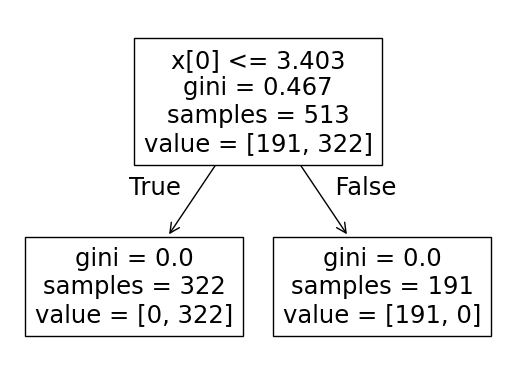

In [76]:
from sklearn.tree import plot_tree
plot_tree(cur_clf)

# Orig results

As proof of concept it is a bit better than default linear kernel + dt.

## Run it for multiple datasets

In [90]:
from sklearn.base import BaseEstimator, clone
from sklearn.metrics import accuracy_score, f1_score

class KernelBased(BaseEstimator):
    
    
    def __init__(self, 
                 strategy='signed', 
                 metric='linear', 
                 clf=DecisionTreeClassifier(max_depth=None, random_state=random_state)):
        
        self.available_strategies = ['signed', 'orig', 'signed_reduced']
        
        self.clf = clf
        self.strategy = strategy
        if self.strategy not in self.available_strategies:
            raise NotImplementedError(f"Available strategies are: {self.available_strategies}. Was given {self.strategy}")
        self.metric = metric
        self.X_train = []
        self.y_train = []
    
    def fit(self, X, y):
        
        y[y==0] = -1
        if set(y.tolist()) != set([-1,1]):
            raise AttributeError(f"Y is expected to be [-1,1] only but contains: {set(y)}")
        
        self.X_train = X
        self.y_train = y.reshape(1,-1)
        
        X_tr = self.transform(X)
            
        self.clf.fit(X_tr, y)
        return self
    
    def predict(self, X):
        X_tr = self.transform(X)
        return self.clf.predict(X_tr)
        
    def predict_proba(self, X):
        X_tr = self.transform(X)
        return self.clf.predict_proba(X_tr)
    
    def transform(self, X):
        X_2_train = pairwise_kernels(X, self.X_train, metric=self.metric)
        if self.strategy == 'signed':
            y_train_repeated = np.repeat(self.y_train, repeats=[X.shape[0]], axis=0)
            X_2_train = X_2_train * y_train_repeated
        # In this case we simply keep the min, max and mean distance to each label
        # In total this will have 6 features (min, max, mean to class -1 and the same to class 1)
        if self.strategy == 'signed_reduced':
            pos_tr = X_2_train[:, self.y_train.flatten() == 1]
            neg_tr = X_2_train[:, self.y_train.flatten() == -1]
            feats = []
            for tr in [pos_tr, neg_tr]:
                for aggr in [np.min, np.max, np.mean]:
                    feats.append(aggr(tr, axis=1))
            X_2_train = np.vstack(feats).T
            
        return X_2_train

y[y==0] = -1
for strategy in ['orig', 'signed', 'signed_reduced']:
    clf = KernelBased(strategy= strategy, metric='poly')
    print(strategy)
    y_pred = cross_val_predict(clf, X, y, cv=cv)
    print(classification_report(y, y_pred))
    print(confusion_matrix(y, y_pred))
    print('\n\n')

orig
              precision    recall  f1-score   support

          -1       0.86      0.84      0.85       212
           1       0.91      0.92      0.91       357

    accuracy                           0.89       569
   macro avg       0.89      0.88      0.88       569
weighted avg       0.89      0.89      0.89       569

[[178  34]
 [ 28 329]]



signed
              precision    recall  f1-score   support

          -1       0.87      0.84      0.85       212
           1       0.91      0.92      0.92       357

    accuracy                           0.89       569
   macro avg       0.89      0.88      0.88       569
weighted avg       0.89      0.89      0.89       569

[[178  34]
 [ 27 330]]



signed_reduced
              precision    recall  f1-score   support

          -1       0.81      0.82      0.81       212
           1       0.89      0.88      0.89       357

    accuracy                           0.86       569
   macro avg       0.85      0.85      0.85      

## Signed Reduced does not seem to work as is

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import numpy as np
import pandas as pd
from sympy import re
from torch import rand
import cached_path
import time
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support



random_state = 42

number_of_cv_folds = 5

cv = StratifiedKFold(number_of_cv_folds, random_state=random_state, shuffle=True)

model_names = [
    "DT",
    'linear_svm',
    'poly_svm',
    'linear_orig_',
    'linear_signed_',
    #'poly_orig_',
    #'poly_signed_',
]


def set_seeds(seed=42):
    np.random.seed(seed)
    

set_seeds(random_state)

path_to_data_summary = "https://raw.githubusercontent.com/EpistasisLab/pmlb/master/pmlb/all_summary_stats.tsv"
dataset_df = pd.read_csv(cached_path.cached_path(path_to_data_summary), sep="\t")

classification_datasets = dataset_df[
    # (dataset_df["n_binary_features"] == dataset_df["n_features"])
    (dataset_df["task"] == "classification")
    & (dataset_df["n_classes"] == 2)
    & (dataset_df["n_features"] <= 100)
    & (dataset_df["n_instances"] <= 1000)
]["dataset"]

print(len(classification_datasets))

res = []
for dataset_index, classification_dataset in enumerate(classification_datasets[::-1][1:]):
    
    print(f"{classification_dataset} ({dataset_index + 1}/{len(classification_datasets) + 1})")
    X, y = fetch_data(classification_dataset, return_X_y=True)
    if y.max() != 1 or y.min() != 0:
        for wanted, actual in enumerate(np.unique(y)):
            y[y==actual] = wanted
    y[y==0] = -1

    
        # train_X, test_X, train_y, test_y = train_test_split(
        #     X, y, stratify=y, test_size=0.2, random_state=random_state
        # )
    for model_name in model_names:
        #print(model_name)
        if "DT" in model_name:
            clf = DecisionTreeClassifier(
                random_state=random_state
            )
        elif 'svm' in model_name:
            if 'linear' in model_name:
                clf = SVC()
            else:
                clf = SVC(kernel='poly')
        else: 
            details = model_name.split('_')
            metric, strategy = details[0], details[1]
            clf = KernelBased(strategy=strategy, metric=metric)
        model = clf
        time_s = time.time()

        y_pred = cross_val_predict(model, X, y, cv=cv).astype(int)
        acc = accuracy_score(y, y_pred)
        (prec, rec, f1, sup) = precision_recall_fscore_support(
            y, y_pred, average="binary"
        )
        time_end = time.time() - time_s
        res.append((classification_dataset, model_name, time_end, acc, prec, rec, f1, sup))
        #print(res[-1])

res = pd.DataFrame(res, columns=['dataset', 'model', 'time', 'acc', 'pr', 'rec', 'f1', 'sup'])
# res.sort_values('f1', ascending=False)

# Step 2: Sort each group by 'f1'
sorted_df = res.groupby('dataset').apply(lambda x: x.sort_values(by='f1', ascending=False)).reset_index(drop=True)

# Step 3: Assign ranks within each group
sorted_df['rank'] = sorted_df.groupby('dataset').cumcount() + 1

# Step 4: Calculate mean rank for each model across all datasets
mean_ranks = sorted_df.groupby('model')['rank'].mean().reset_index().sort_values(by='rank')

print(mean_ranks)

63
wdbc (1/64)
vote (2/64)
tokyo1 (3/64)
tic_tac_toe (4/64)
threeOf9 (5/64)
spectf (6/64)
spect (7/64)
sonar (8/64)
saheart (9/64)
profb (10/64)


/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


prnn_synth (11/64)
prnn_crabs (12/64)
postoperative_patient_data (13/64)


/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


pima (14/64)
parity5 (15/64)
mux6 (16/64)
monk3 (17/64)
monk2 (18/64)
monk1 (19/64)
molecular_biology_promoters (20/64)
lupus (21/64)
labor (22/64)
irish (23/64)
ionosphere (24/64)
hungarian (25/64)


/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


house_votes_84 (26/64)
horse_colic (27/64)
hepatitis (28/64)
heart_statlog (29/64)
heart_h (30/64)
heart_c (31/64)
haberman (32/64)
glass2 (33/64)


/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


german (34/64)
diabetes (35/64)
crx (36/64)
credit_g (37/64)
credit_a (38/64)
corral (39/64)
colic (40/64)
cleve (41/64)
bupa (42/64)
buggyCrx (43/64)
breast_w (44/64)
breast_cancer_wisconsin (45/64)
breast_cancer (46/64)
breast (47/64)


/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


biomed (48/64)
backache (49/64)


/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


australian (50/64)
appendicitis (51/64)
analcatdata_lawsuit (52/64)
analcatdata_japansolvent (53/64)
analcatdata_fraud (54/64)


/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


analcatdata_cyyoung9302 (55/64)


/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


analcatdata_cyyoung8092 (56/64)


/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kbougatiotis/miniconda3/envs/prime/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


analcatdata_creditscore (57/64)
analcatdata_boxing2 (58/64)
analcatdata_boxing1 (59/64)
analcatdata_bankruptcy (60/64)
analcatdata_asbestos (61/64)
analcatdata_aids (62/64)
            model      rank
0              DT  2.064516
3      linear_svm  3.032258
4        poly_svm  3.161290
1    linear_orig_  3.354839
2  linear_signed_  3.387097


/tmp/ipykernel_2921602/822336845.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_df = res.groupby('dataset').apply(lambda x: x.sort_values(by='f1', ascending=False)).reset_index(drop=True)


In [59]:
#  res.groupby('dataset').apply(lambda x: x.sort_values(by='f1', ascending=False))
wins_score = np.zeros((len(model_names), len(model_names)))

score_to_use = 'f1'

for classification_dataset in res['dataset'].unique():
    cur_df = res[res['dataset'] == classification_dataset]
    # print(classification_dataset)
    # print(cur_df.sort_values('f1', ascending=False)[['model', 'time', 'acc', 'f1']])
    # print()
    cur_df = cur_df.set_index('model')
    score_metric = cur_df[score_to_use]
    for i, m1 in enumerate(model_names):
        for j, m2 in enumerate(model_names[i:]):
            if cur_df.loc[m1][score_to_use] > cur_df.loc[m2][score_to_use]:
                wins_score[i, j+i] += 1
            elif cur_df.loc[m1][score_to_use] < cur_df.loc[m2][score_to_use]:
                wins_score[j+i, i] += 1
            else:
                pass
order_of_models = wins_score.mean(axis=1).argsort()[::-1]
wins_score = wins_score[order_of_models, :][:, order_of_models]
print('WINS')
print(pd.DataFrame(wins_score, columns = np.array(model_names)[order_of_models], index=np.array(model_names)[order_of_models]))

WINS
                  DT  linear_svm  poly_svm  linear_signed_  linear_orig_
DT               0.0        42.0      41.0            47.0          45.0
linear_svm      19.0         0.0      26.0            33.0          34.0
poly_svm        19.0        26.0       0.0            32.0          34.0
linear_signed_  14.0        29.0      28.0             0.0          29.0
linear_orig_    14.0        28.0      27.0            23.0           0.0


## Pairwise signing of the gramm matrix


1. For the train gramm matrix, sign it based on the pairwise KNOWN labels with -1 for different and + 1 with same.
2. Do the same at test time, by creating two X_test_to_train distance matrices where we assume different labels for each test sample. e.g. test_sample_1 being of label 1 or -1, test_sample_2 being of label 1 or 1
3. 


In [ ]:
0, -0.5, +0.5, -0.5

In [16]:
X_train = [[+0.0, -0.5, +0.3], 
           [-0.5, +0.0, -0.7], 
           [+0.3, +0.5, +0.0]]
 
X_tr = np.array(X_train)

means = np.mean(X_tr, axis=0)
stds = np.cov(X_tr, rowvar=False)

from scipy.stats import multivariate_normal

g = multivariate_normal(means, stds, allow_singular=True, seed=42)
g.pdf(X_train)

array([0.2438466, 0.2438466, 0.2438466])

In [19]:
means

array([-0.06666667,  0.        , -0.13333333])

In [17]:
g.pdf(np.array([[+0.2, -0.8, +0.4], [-0.2, +0.8, -0.4]]))

array([0., 0.])

In [ ]:
X_train = [[0, 0.5, 0.3], 
           [0.5, 0, 0.7], 
           [0.3, 0.5, 0]] - > X_train * y_train [1,-1,1] - >
 
X_train = [[+0.0, -0.5, +0.3], 
           [-0.5, +0.0, -0.7], 
           [+0.3, +0.5, +0.0]] 
 
X_train = [[1, -1, +1], -> 1
           [-1, 1, -1], -> -1
           [1, -1, 1]] -> 1




X_test =  [[0.2, 0.8, 0.4]] * y_train  = [[+0.2, -0,8, +0.4]] 

# if test label 1
X_test =  [[+0.2, -0.8, +0.4]]

X_test_1 = [1,-1,1], - > proba_pos = 0.6
# if test label -1 
X_test =  [[-0.2, +0.8, -0.4]]

X_test__1 = [-1,1,-1]  - > proba_pos = 0.1

p(f_test | l_test=1, X), p(f_test | l_test=-1, X)